In [35]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pandas_datareader as pdr

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import yfinance as yf
from tqdm.autonotebook import tqdm
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [36]:
def get_info(ticker_obj):
    info_keys = ['shortName']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values)

In [37]:
interesting_tickers = ['BTC-USD','ETH-USD', 'BNB-USD', 'ADA-USD', 'DOGE-USD', 'SHIB-USD', 'LTC-USD', 'ETC-USD', 
           'BCH-USD', 'VET-USD', 'FIL-USD', 'SNX-USD', 'KAVA-USD', 'TWT-USD', 'KSM-USD', 'YFI-USD',
          'UTK-USD', 'RPL-USD', 'SOL-USD', '1INCH-USD', 'THETA-USD', 'OCEAN-USD', 'CHR-USD', 'WRX-USD',
          'DENT-USD', 'DNT-USD', 'CRV-USD', 'DOT-USD', 'KEY-USD', 'BEAM-USD', 'MATIC-USD', 'HEX-USD',
           'AAVE-USD', 'EGLD-USD', 'BTT-USD', 'CAKE-USD', 'HNT-USD', 'DASH-USD', 'ZIL-USD','XDC-USD',
           'KSM-USD','CEL-USD', 'QTUM-USD', 'GLM-USD', 'WAXP-USD', 'NFLX-USD', 'QNT-USD', 'AAPL-USD',
          'NVDA-USD', 'GOOGL-USD']
load = False

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):  #tqdm - помогает понять, сколько уже сделано (визуальная стркоа загрузки)
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='1y', interval='1d')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    full_ticker_df = pd.DataFrame(full_ticker_data)
    full_ticker_df.to_csv("C:/ЦМФ/Project-1. Algo-belikova-zvegincev/full_ticker_df_month_01_2022.csv")

else: 
    full_ticker_df = pd.read_csv("C:/ЦМФ/Project-1. Algo-belikova-zvegincev/full_ticker_df_month_01_2022.csv", index_col=0)
    datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
    full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

  0%|          | 0/50 [00:00<?, ?it/s]

In [38]:
#full_ticker_df.isnull().sum(axis=1)
full_ticker_df.shape

(50, 367)

In [39]:
full_ticker_df.head()

,shortName,2021-10-03 00:00:00,2021-10-04 00:00:00,2021-10-05 00:00:00,2021-10-06 00:00:00,2021-10-07 00:00:00,2021-10-08 00:00:00,2021-10-09 00:00:00,2021-10-10 00:00:00,2021-10-11 00:00:00,...,2022-09-24 00:00:00,2022-09-25 00:00:00,2022-09-26 00:00:00,2022-09-27 00:00:00,2022-09-28 00:00:00,2022-09-29 00:00:00,2022-09-30 00:00:00,2022-10-01 00:00:00,2022-10-02 00:00:00,2022-10-03 00:00:00
0,Bitcoin USD,48199.953125,49112.902344,51514.812500,55361.449219,53805.984375,53967.847656,54968.222656,54771.578125,57484.789062,...,18937.011719,18802.097656,19222.671875,19110.546875,19426.720703,19573.050781,19431.789062,19312.095703,19044.107422,19491.060547
1,Ethereum USD,3418.358643,3380.089111,3518.518555,3580.562012,3587.974854,3563.759277,3575.716797,3425.852783,3545.354004,...,1317.993286,1294.216797,1335.320190,1330.127686,1337.410889,1335.652344,1327.978638,1311.644409,1276.093506,1324.460938
2,BNB USD,430.508820,425.748901,442.706146,435.401367,438.761749,419.102051,421.549469,405.069305,413.456207,...,275.135376,274.061249,275.927856,272.401550,281.781219,283.789032,284.192291,282.871918,284.433105,287.864044
3,Cardano USD,2.252873,2.189235,2.233124,2.212155,2.276995,2.237176,2.266615,2.197214,2.173389,...,0.451600,0.446188,0.446757,0.441890,0.437290,0.438170,0.434414,0.430293,0.419633,0.425999
4,Dogecoin USD,0.221748,0.240852,0.252016,0.255134,0.242923,0.243851,0.246596,0.229805,0.231503,...,0.063234,0.061152,0.061089,0.060609,0.060623,0.060728,0.061653,0.060627,0.059288,0.060259


In [40]:
full_ticker_df = full_ticker_df.iloc[:, :-1]
prices = full_ticker_df.iloc[:, 5:].T
prices = prices.fillna(method='backfill')
prices = prices.fillna(method='ffill')
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T)

In [41]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:].T).T

# KMeans

  0%|          | 0/28 [00:00<?, ?it/s]

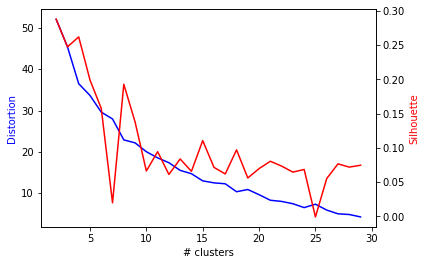

In [42]:
distortions = []
silhouette = []
K = range(2,30)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="euclidean"))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()  #Правило локтя - помогает определить какое кол-во кластеров нужно и возможно сделать.

In [43]:
n_clusters = 3
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_jobs=6)

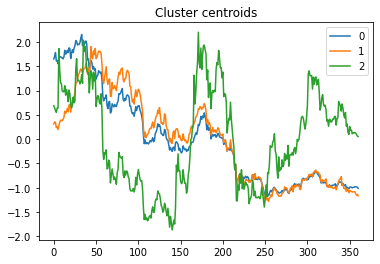

In [44]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [45]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [46]:
full_ticker_df['cluster'] = ts_kmeans.predict(tickers_scaled)

                          Cluster number: 0


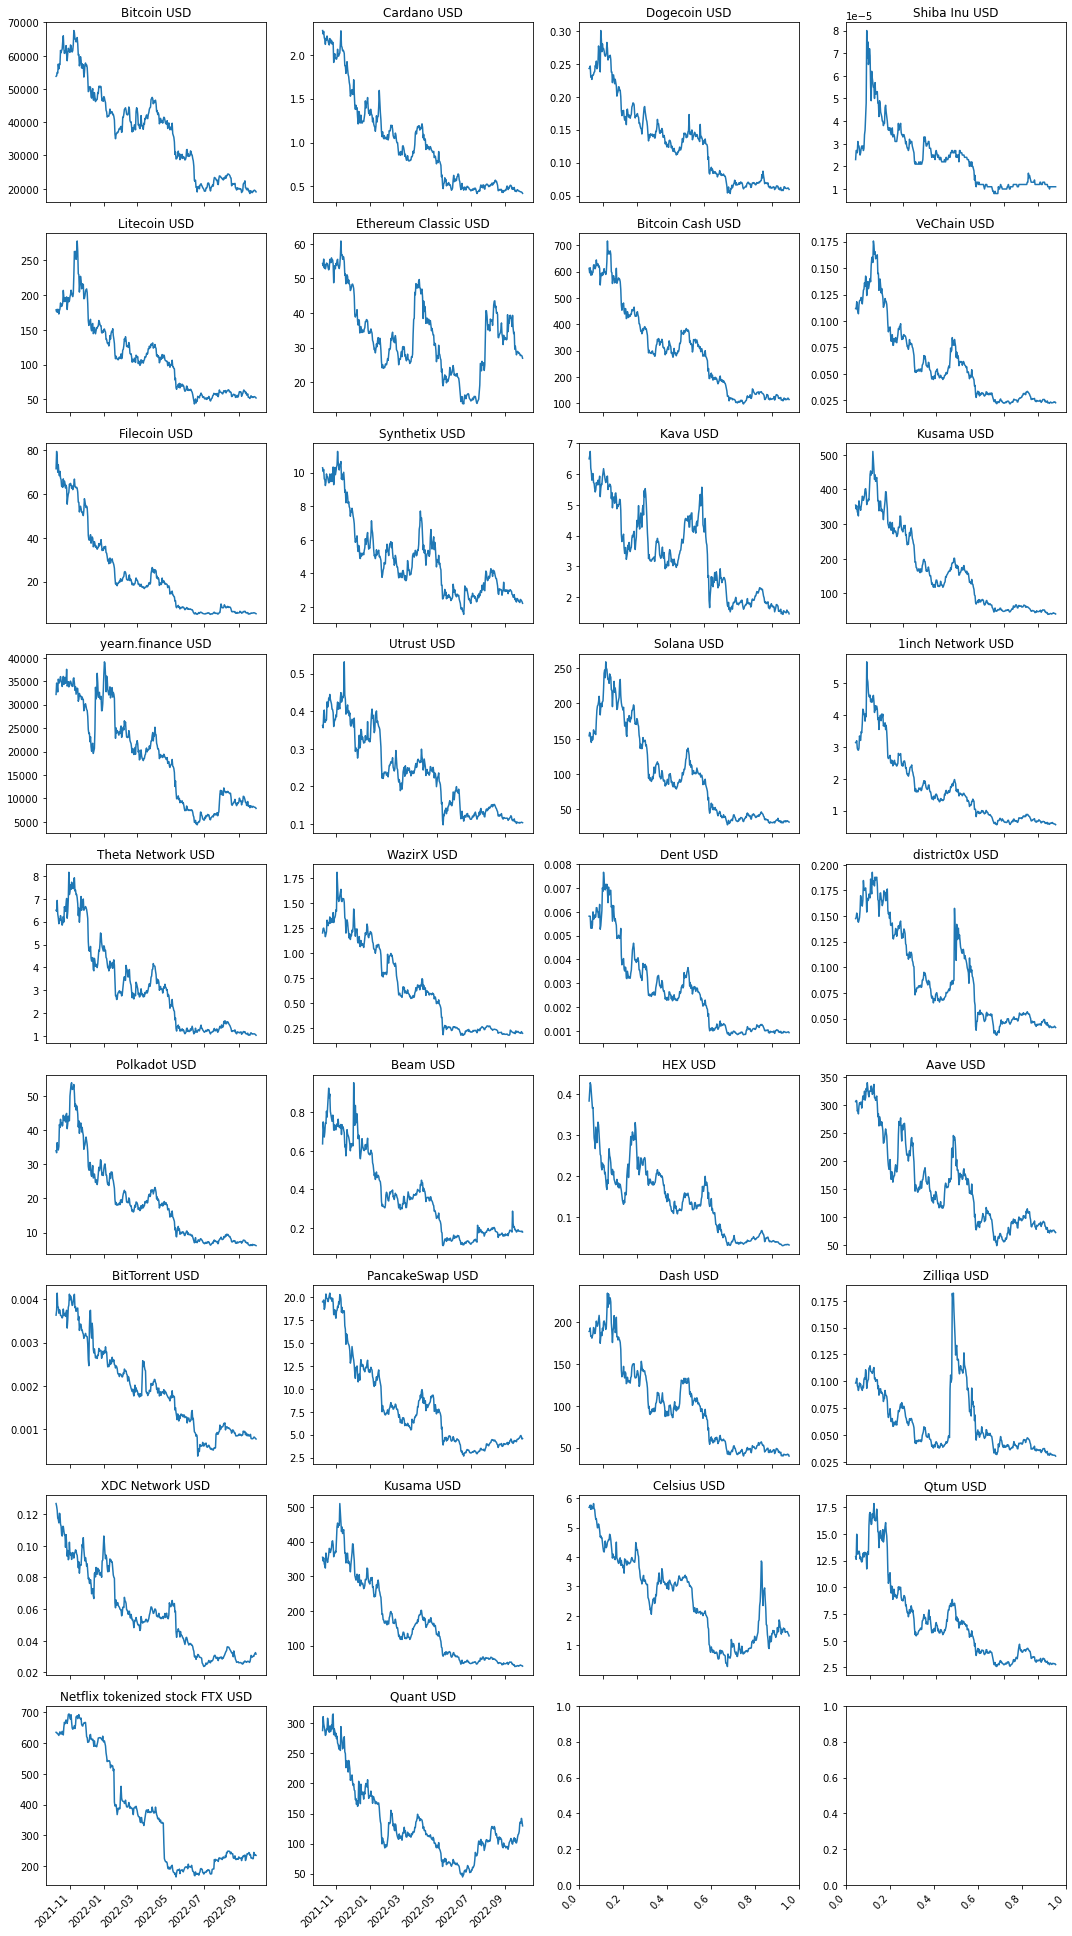

                          Cluster number: 1


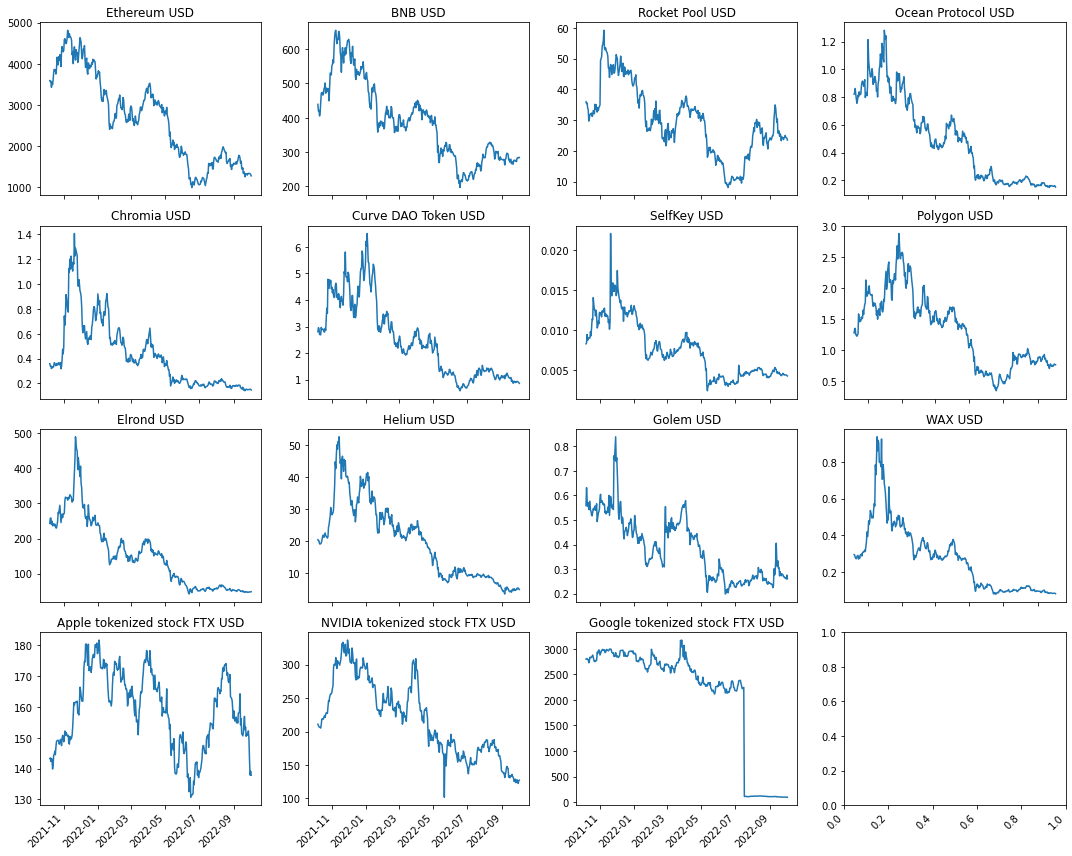

                          Cluster number: 2


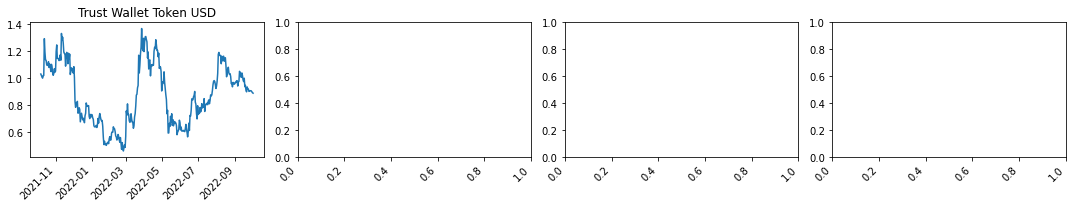

In [47]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

# Иерархическая кластеризация

In [48]:
full_ticker_df_2 = full_ticker_df
link = linkage(full_ticker_df_2.iloc[:,2:], 'ward', 'euclidean')

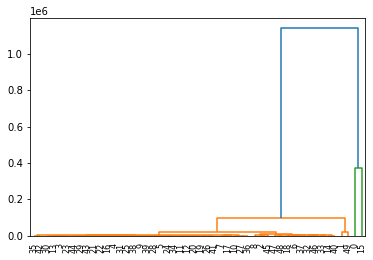

In [49]:
dn = dendrogram(link, orientation='top')
full_ticker_df_2['cluster'] = fcluster(link, 2, criterion='maxclust')

In [52]:
full_ticker_df_2.head()

,shortName,2021-10-03 00:00:00,2021-10-04 00:00:00,2021-10-05 00:00:00,2021-10-06 00:00:00,2021-10-07 00:00:00,2021-10-08 00:00:00,2021-10-09 00:00:00,2021-10-10 00:00:00,2021-10-11 00:00:00,...,2022-09-24 00:00:00,2022-09-25 00:00:00,2022-09-26 00:00:00,2022-09-27 00:00:00,2022-09-28 00:00:00,2022-09-29 00:00:00,2022-09-30 00:00:00,2022-10-01 00:00:00,2022-10-02 00:00:00,cluster
0,Bitcoin USD,48199.953125,49112.902344,51514.812500,55361.449219,53805.984375,53967.847656,54968.222656,54771.578125,57484.789062,...,18937.011719,18802.097656,19222.671875,19110.546875,19426.720703,19573.050781,19431.789062,19312.095703,19044.107422,2
1,Ethereum USD,3418.358643,3380.089111,3518.518555,3580.562012,3587.974854,3563.759277,3575.716797,3425.852783,3545.354004,...,1317.993286,1294.216797,1335.320190,1330.127686,1337.410889,1335.652344,1327.978638,1311.644409,1276.093506,1
2,BNB USD,430.508820,425.748901,442.706146,435.401367,438.761749,419.102051,421.549469,405.069305,413.456207,...,275.135376,274.061249,275.927856,272.401550,281.781219,283.789032,284.192291,282.871918,284.433105,1
3,Cardano USD,2.252873,2.189235,2.233124,2.212155,2.276995,2.237176,2.266615,2.197214,2.173389,...,0.451600,0.446188,0.446757,0.441890,0.437290,0.438170,0.434414,0.430293,0.419633,1
4,Dogecoin USD,0.221748,0.240852,0.252016,0.255134,0.242923,0.243851,0.246596,0.229805,0.231503,...,0.063234,0.061152,0.061089,0.060609,0.060623,0.060728,0.061653,0.060627,0.059288,1


                          Cluster number: 1


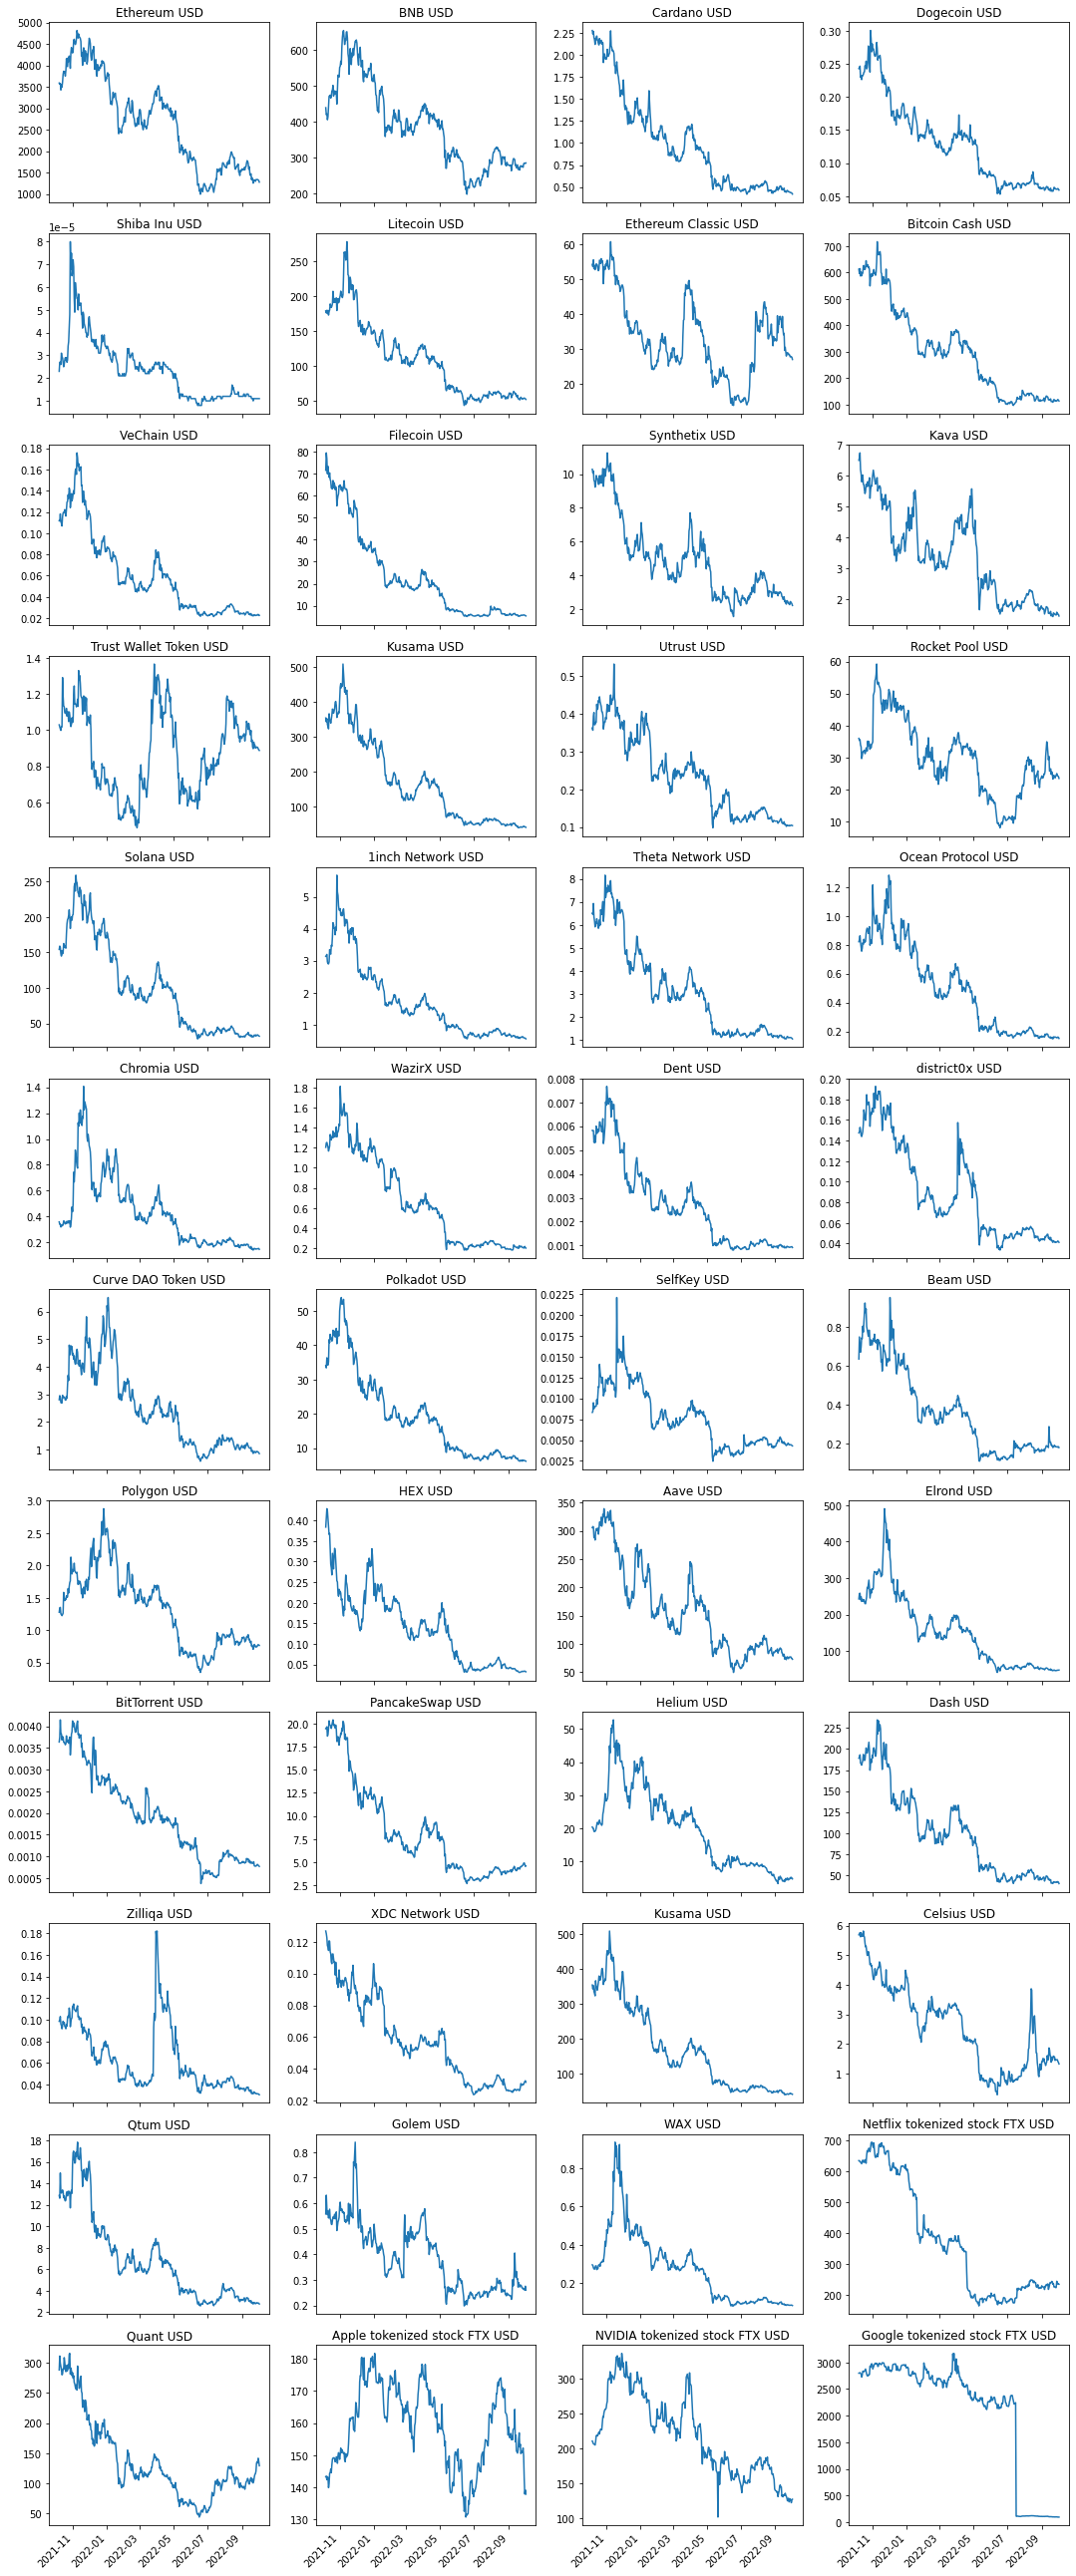

                          Cluster number: 2


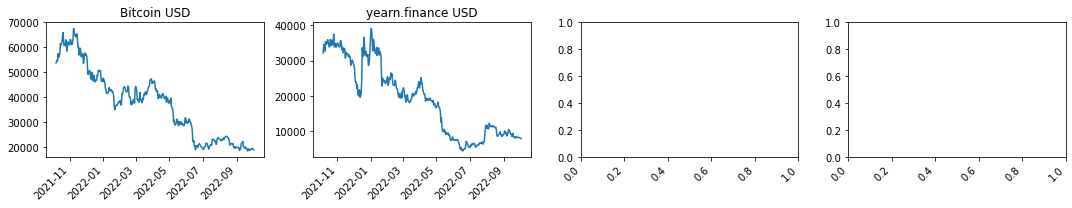

In [51]:
n_clusters_2 = 2
for cluster in range(1,n_clusters_2+1):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df_2[full_ticker_df_2.cluster==cluster])